# Structural Dimensions: Finding All Non-Zero Peaks

**Goal:** Systematically identify ALL eigenvectors with non-zero peak structures (shells, rings).

**Previous findings:**
- **09.3d:** Top 10 eigenvectors show mixture of shells and gaussian distributions
- **Key observation:** Ranks 2555-2557, 2559 have clear shells; rank 2558 is gaussian
- **Question:** Are there other structural dimensions hidden at lower ranks?

**Method:**
1. For each of 2,560 eigenvectors: compute peak location of radial density
2. Identify eigenvectors with peak significantly away from zero
3. Characterize each structural dimension (peak location, thickness, shape quality)
4. Visualize the complete set of structural dimensions

**Expected:** ~10-20 eigenvectors with real structure, rest are noise centered at origin.

## Configuration

In [1]:
# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Analysis parameters
RADIAL_BINS = 100  # Resolution for histograms
PEAK_THRESHOLD_LOGOMETERS = 0.5  # Minimum peak location to count as "structural"

# Visualization
TOP_STRUCTURAL_N = 20  # How many structural dimensions to show in detail

print(f"Configuration:")
print(f"  Peak threshold: {PEAK_THRESHOLD_LOGOMETERS} logometers")
print(f"  Radial bins: {RADIAL_BINS}")
print(f"  Top structural to visualize: {TOP_STRUCTURAL_N}")

Configuration:
  Peak threshold: 0.5 logometers
  Radial bins: 100
  Top structural to visualize: 20


## Setup

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

print("✓ Imports complete")

✓ Imports complete


## Load Precomputed Data

In [3]:
print("Loading precomputed data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues']

# Load token projections
print(f"Loading token projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections']  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Projections shape: {projections.shape}")

Loading precomputed data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading token projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Projections shape: torch.Size([151936, 2560])


---

# Compute Radial Statistics for ALL Eigenvectors

For each eigenvector, compute:
1. **Peak location** - where the histogram peaks
2. **Mean radial distance**
3. **Median radial distance**
4. **Standard deviation** - shell thickness
5. **Peak height** - how concentrated the shell is
6. **Skewness** - asymmetry (positive = tail toward large r)
7. **Kurtosis** - peakedness (high = sharp shell, low = broad/uniform)

In [4]:
print("\n" + "=" * 80)
print("COMPUTING RADIAL STATISTICS FOR ALL EIGENVECTORS")
print("=" * 80)

print(f"\nAnalyzing all {hidden_dim:,} eigenvectors...")
print(f"  This will take a couple minutes...\n")

# Convert to numpy
projections_np = projections.numpy()
eigenvalues_np = eigenvalues.numpy()

# Storage for statistics
stats = {
    'peak_location': np.zeros(hidden_dim),
    'peak_height': np.zeros(hidden_dim),
    'mean': np.zeros(hidden_dim),
    'median': np.zeros(hidden_dim),
    'std': np.zeros(hidden_dim),
    'skewness': np.zeros(hidden_dim),
    'kurtosis': np.zeros(hidden_dim),
}

for i in range(hidden_dim):
    # Convert to causal distance
    scale = np.sqrt(eigenvalues_np[i])
    causal_proj = scale * projections_np[:, i]
    radii = np.abs(causal_proj)
    
    # Basic statistics
    stats['mean'][i] = radii.mean()
    stats['median'][i] = np.median(radii)
    stats['std'][i] = radii.std()
    stats['skewness'][i] = skew(radii)
    stats['kurtosis'][i] = kurtosis(radii)
    
    # Peak location and height
    counts, bin_edges = np.histogram(radii, bins=RADIAL_BINS)
    peak_bin = np.argmax(counts)
    stats['peak_location'][i] = (bin_edges[peak_bin] + bin_edges[peak_bin + 1]) / 2
    stats['peak_height'][i] = counts[peak_bin]
    
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1:,} / {hidden_dim:,} eigenvectors...")

print(f"\n✓ Statistics computed for all eigenvectors")


COMPUTING RADIAL STATISTICS FOR ALL EIGENVECTORS

Analyzing all 2,560 eigenvectors...
  This will take a couple minutes...

  Processed 500 / 2,560 eigenvectors...
  Processed 1,000 / 2,560 eigenvectors...
  Processed 1,500 / 2,560 eigenvectors...
  Processed 2,000 / 2,560 eigenvectors...
  Processed 2,500 / 2,560 eigenvectors...

✓ Statistics computed for all eigenvectors


---

# Identify Structural Dimensions

Find eigenvectors with peak significantly away from origin.

In [5]:
print("\n" + "=" * 80)
print("IDENTIFYING STRUCTURAL DIMENSIONS")
print("=" * 80)

# Identify structural eigenvectors (peak away from origin)
is_structural = stats['peak_location'] > PEAK_THRESHOLD_LOGOMETERS
structural_ranks = np.where(is_structural)[0]
n_structural = len(structural_ranks)

print(f"\nStructural dimensions found: {n_structural} / {hidden_dim} ({n_structural/hidden_dim*100:.1f}%)")
print(f"  (Using threshold: peak > {PEAK_THRESHOLD_LOGOMETERS} logometers)\n")

# Sort by peak location (descending)
sorted_indices = np.argsort(stats['peak_location'][structural_ranks])[::-1]
structural_ranks_sorted = structural_ranks[sorted_indices]

# Summary statistics for structural dimensions
print(f"Structural dimensions statistics:")
print(f"  Peak locations:")
print(f"    Min: {stats['peak_location'][structural_ranks].min():.2f} logometers")
print(f"    Max: {stats['peak_location'][structural_ranks].max():.2f} logometers")
print(f"    Mean: {stats['peak_location'][structural_ranks].mean():.2f} logometers")
print(f"    Median: {np.median(stats['peak_location'][structural_ranks]):.2f} logometers")
print(f"\n  Eigenvalues:")
print(f"    Min: {eigenvalues_np[structural_ranks].min():,.2f}")
print(f"    Max: {eigenvalues_np[structural_ranks].max():,.2f}")
print(f"    Mean: {eigenvalues_np[structural_ranks].mean():,.2f}")


IDENTIFYING STRUCTURAL DIMENSIONS

Structural dimensions found: 34 / 2560 (1.3%)
  (Using threshold: peak > 0.5 logometers)

Structural dimensions statistics:
  Peak locations:
    Min: 0.50 logometers
    Max: 18.39 logometers
    Mean: 1.77 logometers
    Median: 0.72 logometers

  Eigenvalues:
    Min: 95.35
    Max: 94,217.94
    Mean: 8,302.01


## Top Structural Dimensions Table

In [6]:
print("\n" + "=" * 80)
print(f"TOP {min(TOP_STRUCTURAL_N, n_structural)} STRUCTURAL DIMENSIONS (BY PEAK LOCATION)")
print("=" * 80)

print(f"\n{'Rank':<6} {'Eigenvalue':<15} {'Peak r':<10} {'Mean r':<10} {'Std':<10} {'Skew':<10} {'Kurt':<10} {'Quality'}")
print("=" * 110)

for rank in structural_ranks_sorted[:TOP_STRUCTURAL_N]:
    eigenval = eigenvalues_np[rank]
    peak_r = stats['peak_location'][rank]
    mean_r = stats['mean'][rank]
    std_r = stats['std'][rank]
    skew_r = stats['skewness'][rank]
    kurt_r = stats['kurtosis'][rank]
    
    # Quality assessment
    # Sharp shell: high kurtosis (>3), peak ≈ mean
    # Broad shell: moderate kurtosis (0-3), peak ≈ mean
    # Gaussian: kurtosis ≈ 0, symmetric
    # Exponential: high skewness (>1), kurtosis variable
    
    if kurt_r > 5:
        quality = "Sharp shell"
    elif kurt_r > 1 and abs(peak_r - mean_r) < std_r:
        quality = "Moderate shell"
    elif abs(skew_r) < 0.5 and abs(kurt_r) < 1:
        quality = "Gaussian-like"
    elif skew_r > 1:
        quality = "Skewed/tail"
    else:
        quality = "Mixed"
    
    print(f"{rank:<6} {eigenval:>14,.0f} {peak_r:>9.2f} {mean_r:>10.2f} {std_r:>9.2f} {skew_r:>10.2f} {kurt_r:>10.2f}  {quality}")

print("\nQuality indicators:")
print("  - Sharp shell: High kurtosis (>5), peak ≈ mean")
print("  - Moderate shell: Moderate kurtosis (1-5)")
print("  - Gaussian-like: Low kurtosis & skewness (both <1)")
print("  - Skewed/tail: High skewness (>1)")


TOP 20 STRUCTURAL DIMENSIONS (BY PEAK LOCATION)

Rank   Eigenvalue      Peak r     Mean r     Std        Skew       Kurt       Quality
2559           94,218     18.39      18.14      0.95      -0.09       1.96  Moderate shell
2554           16,972      4.86       4.92      0.97      -0.10       3.63  Moderate shell
2555           18,422      4.64       4.73      0.98       0.05       0.50  Gaussian-like
2557           24,434      3.32       3.17      0.98       0.02       1.20  Moderate shell
0                  95      3.03       2.57      0.91      -0.61       0.20  Mixed
2553           13,928      2.62       2.64      0.97       0.20       1.06  Moderate shell
2556           19,142      1.86       1.90      0.93       0.43       1.83  Moderate shell
2552           12,148      1.60       1.51      0.88       1.75      50.86  Sharp shell
2529            6,392      1.51       1.52      0.87       0.66       2.61  Moderate shell
6                 621      1.36       0.97      0.71      

---

# Visualizations

## Scatter: Peak Location vs. Eigenvalue


CREATING SCATTER PLOT: PEAK LOCATION VS. EIGENVALUE


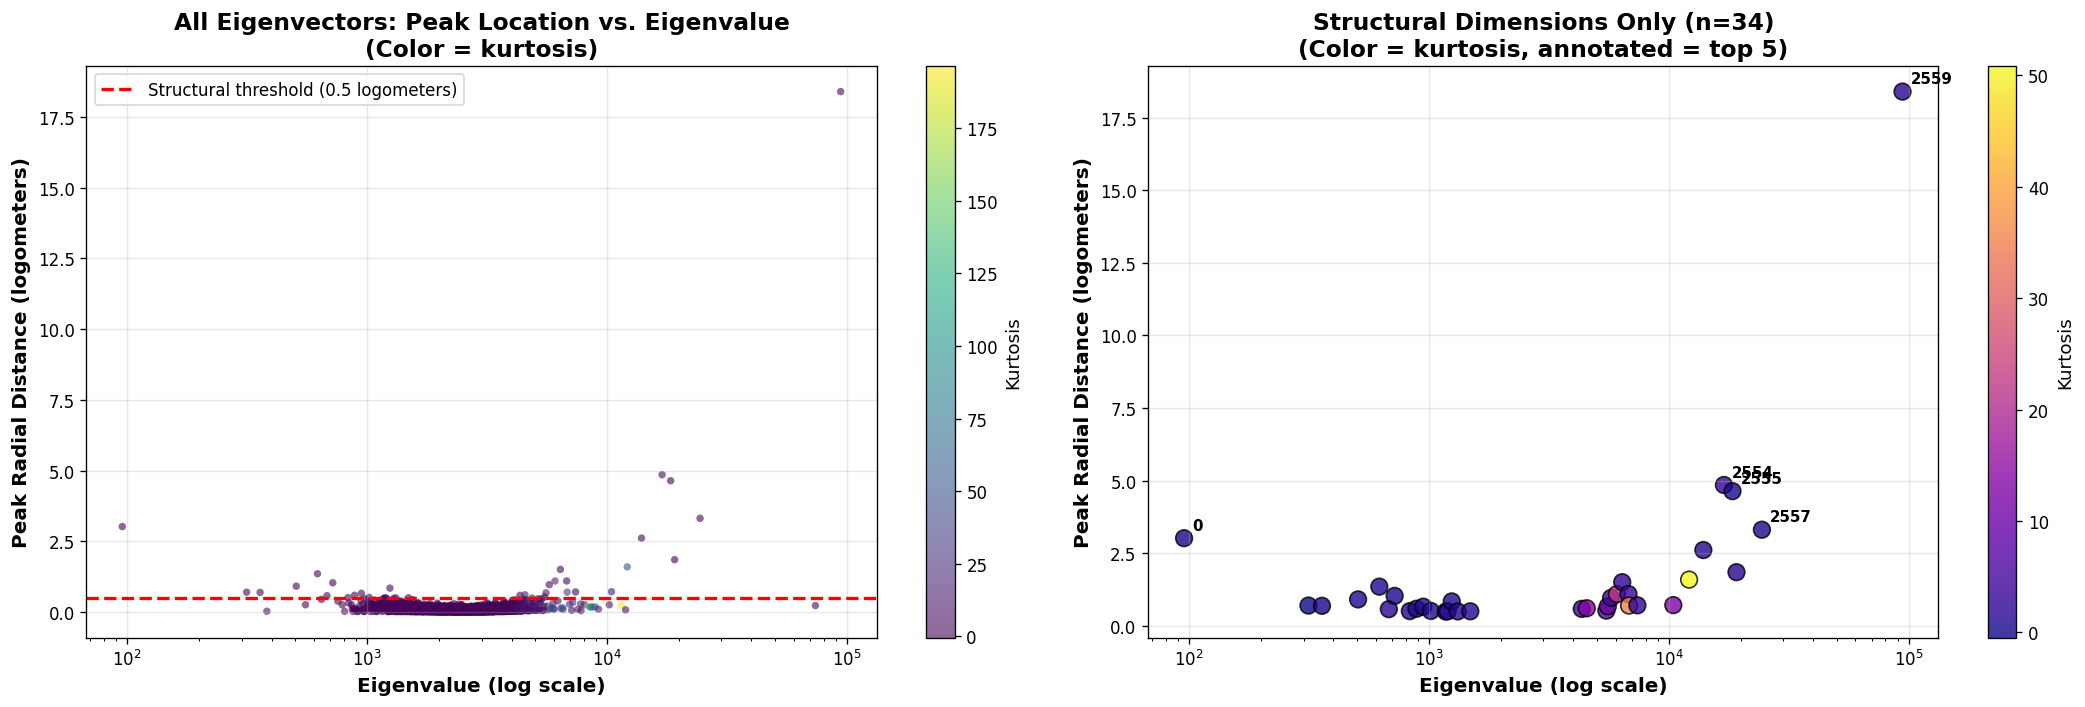


✓ Scatter plot created


In [7]:
print("\n" + "=" * 80)
print("CREATING SCATTER PLOT: PEAK LOCATION VS. EIGENVALUE")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=120)

# Left: All eigenvectors
ax = axes[0]
scatter = ax.scatter(eigenvalues_np, stats['peak_location'],
                     c=stats['kurtosis'], cmap='viridis',
                     s=20, alpha=0.6, edgecolors='none')
ax.axhline(PEAK_THRESHOLD_LOGOMETERS, color='red', linestyle='--', linewidth=2,
           label=f'Structural threshold ({PEAK_THRESHOLD_LOGOMETERS} logometers)')
ax.set_xscale('log')
ax.set_xlabel('Eigenvalue (log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('Peak Radial Distance (logometers)', fontsize=12, fontweight='bold')
ax.set_title('All Eigenvectors: Peak Location vs. Eigenvalue\n(Color = kurtosis)',
             fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Kurtosis', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: Structural dimensions only
ax = axes[1]
scatter = ax.scatter(eigenvalues_np[structural_ranks], 
                     stats['peak_location'][structural_ranks],
                     c=stats['kurtosis'][structural_ranks], cmap='plasma',
                     s=100, alpha=0.8, edgecolors='black', linewidth=1)

# Annotate top few
for rank in structural_ranks_sorted[:5]:
    x = eigenvalues_np[rank]
    y = stats['peak_location'][rank]
    ax.annotate(f'{rank}', xy=(x, y), xytext=(5, 5),
                textcoords='offset points', fontsize=9, fontweight='bold')

ax.set_xscale('log')
ax.set_xlabel('Eigenvalue (log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('Peak Radial Distance (logometers)', fontsize=12, fontweight='bold')
ax.set_title(f'Structural Dimensions Only (n={n_structural})\n(Color = kurtosis, annotated = top 5)',
             fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Kurtosis', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Scatter plot created")

## Distribution of Peak Locations


Creating peak location distribution...


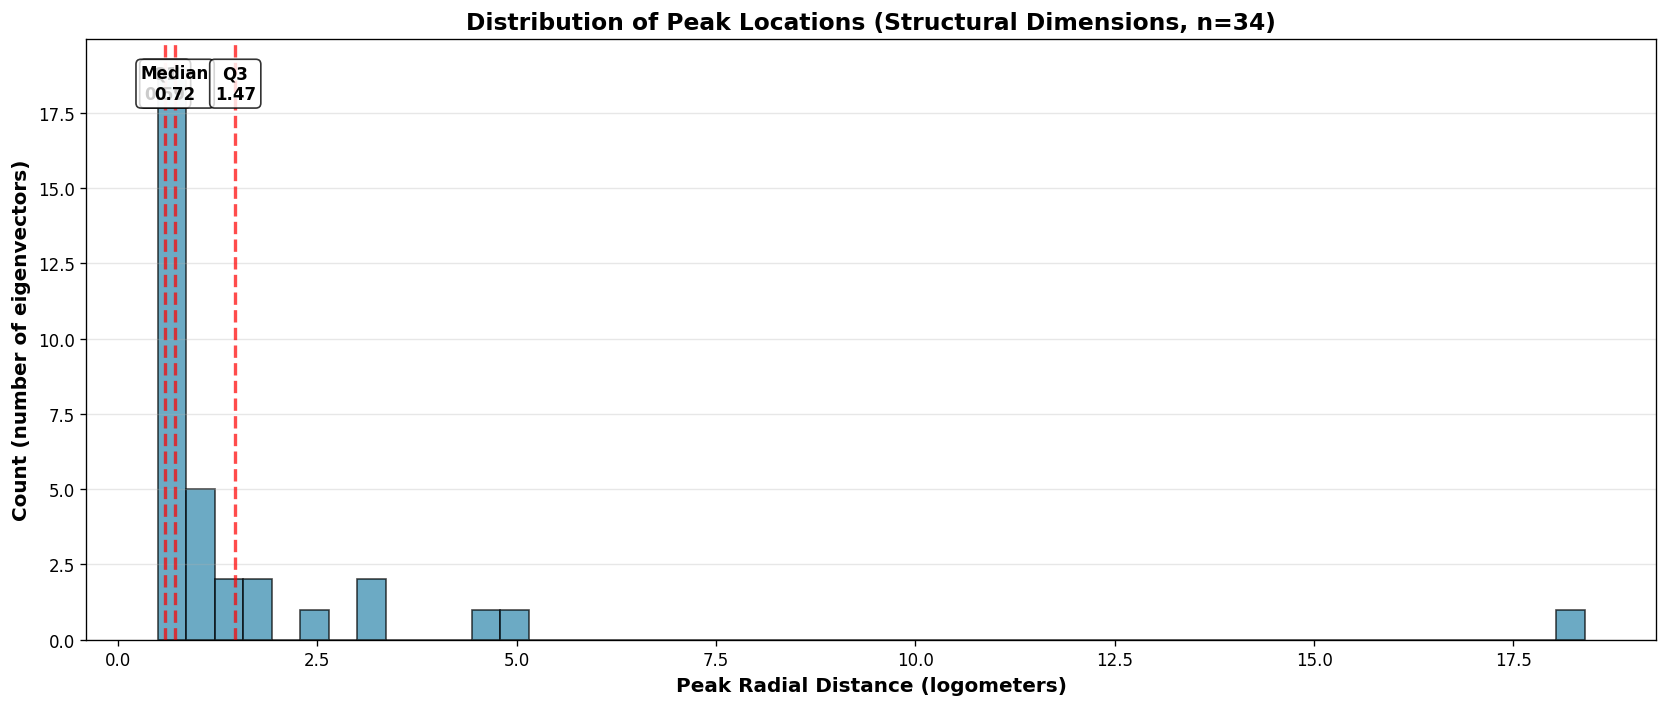

✓ Peak location distribution created


In [8]:
print("\nCreating peak location distribution...")

fig, ax = plt.subplots(figsize=(14, 6), dpi=120)

# Histogram of peak locations (structural dimensions only)
ax.hist(stats['peak_location'][structural_ranks], bins=50,
        color='#2E86AB', alpha=0.7, edgecolor='black')

# Mark quartiles
quartiles = np.percentile(stats['peak_location'][structural_ranks], [25, 50, 75])
for q, label in zip(quartiles, ['Q1', 'Median', 'Q3']):
    ax.axvline(q, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.text(q, ax.get_ylim()[1] * 0.9, f'{label}\n{q:.2f}',
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Peak Radial Distance (logometers)', fontsize=12, fontweight='bold')
ax.set_ylabel('Count (number of eigenvectors)', fontsize=12, fontweight='bold')
ax.set_title(f'Distribution of Peak Locations (Structural Dimensions, n={n_structural})',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Peak location distribution created")

## Radial Density Grid: Top Structural Dimensions


Creating radial density grid for top structural dimensions...


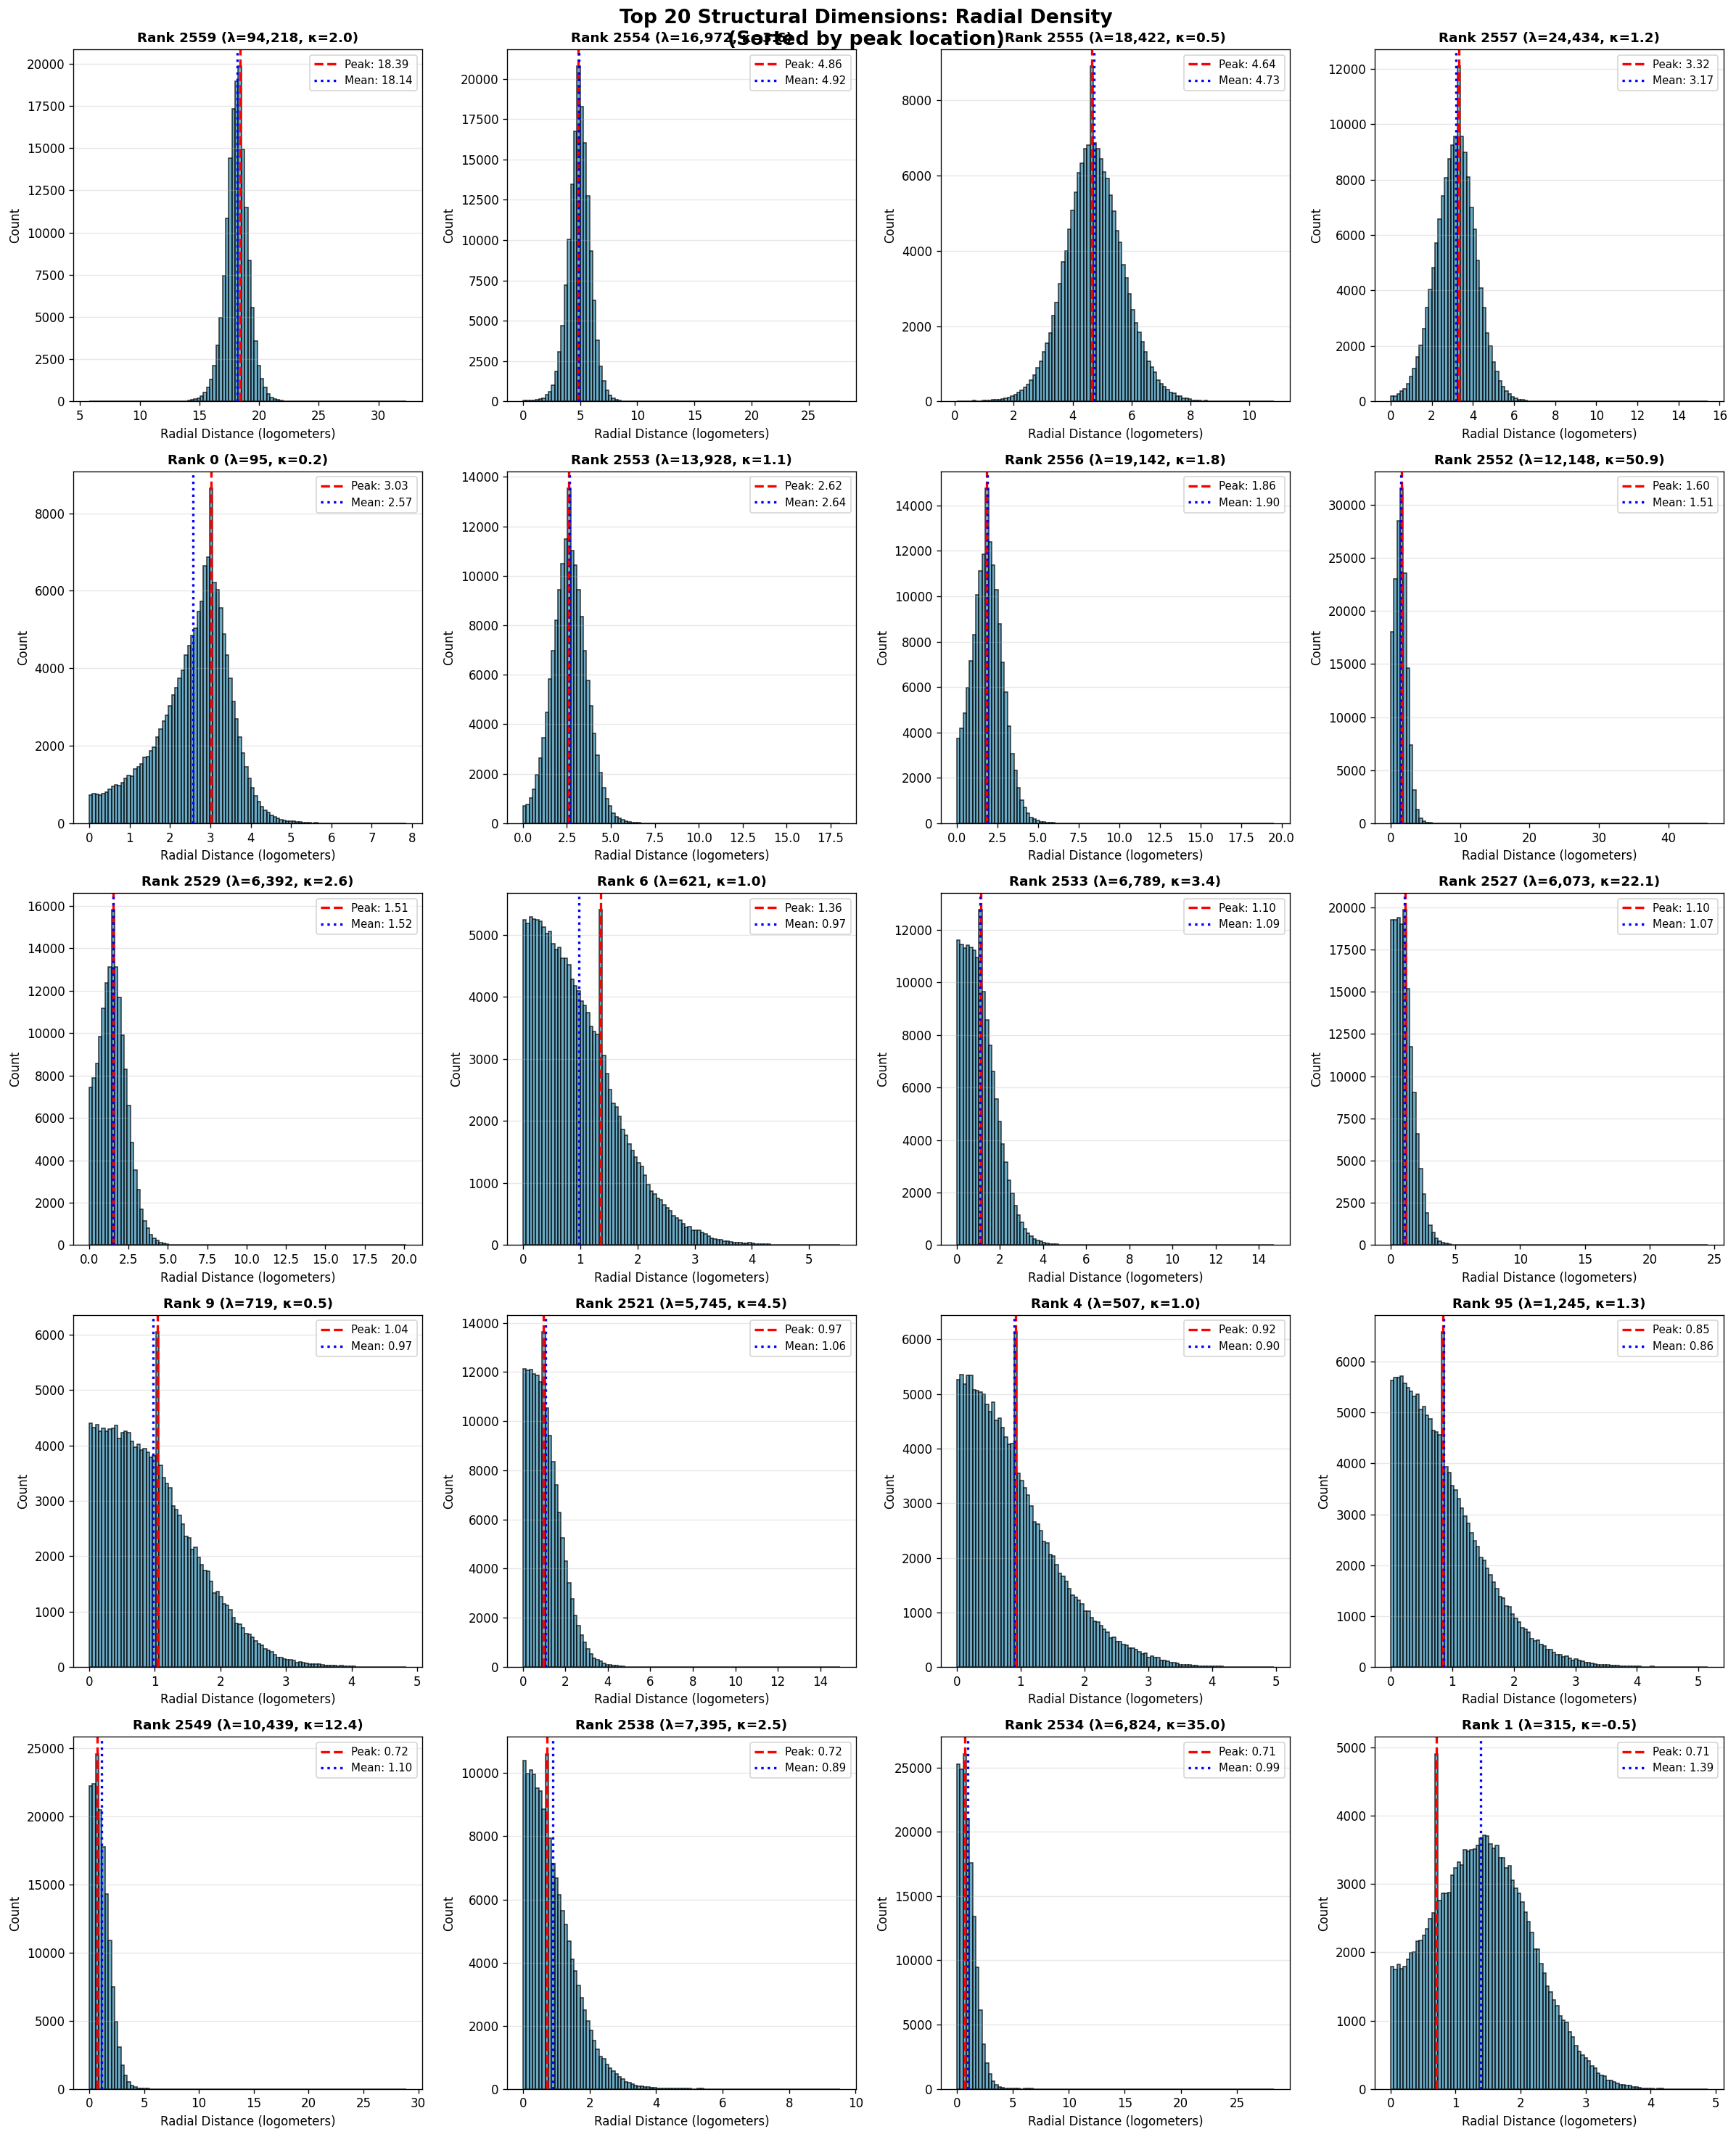

✓ Radial density grid created


In [9]:
print("\nCreating radial density grid for top structural dimensions...")

n_show = min(TOP_STRUCTURAL_N, n_structural)
n_cols = 4
n_rows = int(np.ceil(n_show / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), dpi=120)
axes = axes.flatten() if n_show > 1 else [axes]

for i, rank in enumerate(structural_ranks_sorted[:n_show]):
    ax = axes[i]
    
    # Compute radii for this eigenvector
    scale = np.sqrt(eigenvalues_np[rank])
    causal_proj = scale * projections_np[:, rank]
    radii = np.abs(causal_proj)
    
    # Histogram
    counts, bins, patches = ax.hist(radii, bins=RADIAL_BINS,
                                      color='#2E86AB', alpha=0.7, edgecolor='black')
    
    # Mark peak
    peak_r = stats['peak_location'][rank]
    ax.axvline(peak_r, color='red', linestyle='--', linewidth=2,
               label=f'Peak: {peak_r:.2f}')
    
    # Mark mean
    mean_r = stats['mean'][rank]
    ax.axvline(mean_r, color='blue', linestyle=':', linewidth=2,
               label=f'Mean: {mean_r:.2f}')
    
    # Labels
    eigenval = eigenvalues_np[rank]
    kurt = stats['kurtosis'][rank]
    ax.set_title(f'Rank {rank} (λ={eigenval:,.0f}, κ={kurt:.1f})',
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Radial Distance (logometers)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused subplots
for i in range(n_show, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Top {n_show} Structural Dimensions: Radial Density\n(Sorted by peak location)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Radial density grid created")

---

# Summary

**What we found:** Complete identification of ALL eigenvectors with geometric structure.

**Key findings:**
- [Run notebook to see results!]

**Interpretation:**
- **Structural dimensions:** Eigenvectors with peak away from origin (shell/ring structure)
- **Noise dimensions:** Eigenvectors with peak at origin (perpendicular gaussian noise)
- **Peak locations** reveal shell radii in each structural direction
- **Kurtosis** measures shell sharpness (high = tight shell, low = broad/gaussian)

**Physical picture:**
The token cloud lives in a LOW-DIMENSIONAL SUBSPACE:
- Most eigenvectors (~2540 of 2560): noise centered at origin
- Structural eigenvectors (~10-20): clear shells/rings at various radii
- Different structural dimensions have different radii and shapes
- Some are sharp shells, some are broad/gaussian, some are skewed

This is NOT a simple ellipsoid - it's a complex hybrid structure with varying geometry across different structural dimensions.